# Comprehensive Spectroscopy Function Tests

This notebook provides extensive testing for all functions within the spectroscopy module, ensuring they handle various scenarios correctly and identifying areas for improvement.

## Test Coverage:

### 🔬 **Core Functions Tested:**
- `normalized_gauss(detunings, FWHM_val)` - Normalized Gaussian distribution for inhomogeneous broadening
- `sample_from_sigma(n_samples, FWHM_val, max_detuning)` - Rejection sampling from Gaussian distribution
- `get_tau_cohs_and_t_dets_for_T_wait(T_wait, dt, tau_coh_max, t_det_max)` - Time array generation
- `check_the_solver(rho)` - Density matrix validation (Hermitian, positive semidefinite, unit trace)
- `compute_two_dimensional_polarization(tau_cohs, t_dets, T_wait, pulse_sequence, params)` - 2D spectroscopy calculations

### 🧪 **Test Scenarios:**
- **Edge cases**: Boundary conditions, extreme parameters, and unusual inputs

- **Memory optimization** - Large-scale simulation readiness
- **Error handling** - Input validation and graceful failure

---
**Last Updated:** May 30, 2025

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================

### Standard scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy.stats import norm
from scipy import integrate

### Local spectroscopy modules
from src.spectroscopy.calculations import (
    compute_two_dimensional_polarization,
    get_tau_cohs_and_t_dets_for_T_wait,
    check_the_solver,
    compute_fixed_tau_T,
)
from src.spectroscopy.inhomogenity import (
    sample_from_sigma,
    normalized_gauss
)
from src.core.system_parameters import SystemParameters

from src.visualization import mpl_tex_settings
from src.visualization.plotting import Plot_polarization_2d_spectrum, Plot_example_evo, Plot_fixed_tau_T

# =============================
### Set random seeds for reproducible results
np.random.seed(42)

### Configure warnings
warnings.filterwarnings('ignore', category=UserWarning, module='qutip')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')

## Test 0: inhomogeneous broadening

In [ ]:
### Test sigma function (normalized Gaussian)
print("Testing sigma function (normalized Gaussian distribution)...")

# Test basic functionality
detunings = np.linspace(-5, 5, 40000)
FWHM_val = 2.0
sigma_val = FWHM_val / (2 * np.sqrt(2 * np.log(2)))  # standard deviation from FWHM

gaussian_vals = normalized_gauss(detunings, FWHM_val, mu=0)

# Test normalization (integral should be approximately 1)
delta_det = detunings[1] - detunings[0]
integral = np.trapz(gaussian_vals, dx=delta_det)
print(f"Gaussian normalization test: integral = {integral:.6f} (should be ≈ 1)")
assert abs(integral - 1.0) < 0.01, f"Gaussian not properly normalized: {integral}"

# Test peak at zero
zero_idx = np.argmin(np.abs(detunings))
print(f"Peak at detuning {detunings[zero_idx]:.6f} with value {gaussian_vals[zero_idx]:.6f}")
peak_val = gaussian_vals[zero_idx]
expected_peak = 1.0 / (sigma_val * np.sqrt(2 * np.pi))
print(f"Peak value test: peak = {peak_val:.6f}, expected = {expected_peak:.6f}")
assert abs(peak_val - expected_peak) < 0.01, "Peak value incorrect"




### Test sample_from_sigma function
print("\nTesting sample_from_sigma function (rejection sampling)...")
n_samples = 5000
FWHM_val = 2.0

# Generate samples
samples = sample_from_sigma(n_samples, FWHM_val, mu=0, max_detuning=3.0)

# Test statistical properties
sample_mean = np.mean(samples)
sample_std = np.std(samples)
print(f"Sample statistics: mean = {sample_mean:.6f}, std = {sample_std:.6f}")
print(f"Expected: mean ≈ 0, std ≈ {FWHM_val / (2 * np.sqrt(2 * np.log(2))) :.6f}")

# Mean should be close to zero
assert abs(sample_mean) < 0.1, f"Sample mean too far from zero: {sample_mean}"

# Standard deviation should be close to sigma_val
assert abs(sample_std - FWHM_val / (2 * np.sqrt(2 * np.log(2)))) < 0.2, f"Sample std deviation incorrect: {sample_std}"


### Visualization of sampling results
plt.figure(figsize=(12, 8))

# Plot 2: Sample histogram vs theoretical
plt.subplot(2, 1, 1)
hist_counts, hist_bins, _ = plt.hist(samples, bins=50, density=True, alpha=0.6, 
                                   color='C1', label='Samples')
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
theoretical = normalized_gauss(bin_centers, sigma_val)
plt.plot(bin_centers, theoretical, 'C0', linewidth=2, label='Theoretical')
plt.xlabel(r'Detuning')
plt.ylabel('Probability Density')
plt.title(f'Sample Distribution vs Theoretical\n($N = {n_samples}$ samples)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Cumulative distribution comparison
plt.subplot(2, 1, 2)
sorted_samples = np.sort(samples)
cumulative = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
plt.plot(sorted_samples, cumulative, 'C1', label='Sample CDF', linewidth=2)

# Theoretical CDF (using scipy for accuracy)
from scipy.stats import norm
theoretical_cdf = norm.cdf(sorted_samples, 0, sigma_val)
plt.plot(sorted_samples, theoretical_cdf, 'C0--', label='Theoretical CDF', linewidth=2)
plt.xlabel(r'Detuning')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

Testing sigma function (normalized Gaussian distribution)...
Gaussian normalization test: integral = 1.000000 (should be ≈ 1)
Peak at detuning 0.000125 with value 0.469719
Peak value test: peak = 0.469719, expected = 0.469719

Testing sample_from_sigma function (rejection sampling)...


C:\Users\leopo\AppData\Local\Temp\ipykernel_20184\3538445493.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(gaussian_vals, dx=delta_det)


## Test 1: get_tau_cohs_and_t_dets_for_T_wait

Testing get_tau_cohs_and_t_dets_for_T_wait function...
Generated time arrays:
  Input times: 201 points, range [-2.00, 100.00], dt = 0.510
  T_wait = 50.0
  tau_cohs: 99 points, range [0.00, 49.98]
  t_dets: 99 points, range [0.00, 49.98]

Testing T_wait = t_max (edge case):
  T_wait = t_max = 100.0: tau_cohs length = 1, t_dets length = 1
    Values: tau_coh = [0.], t_det = [0.]

Testing T_wait > t_max (should return empty):
  T_wait = 110.0 > t_max = 100.0: tau_cohs length = 0, t_dets length = 0

Testing single time point:
  Single time point: tau_cohs = [0.], t_dets = [0.]

Creating visualizations...


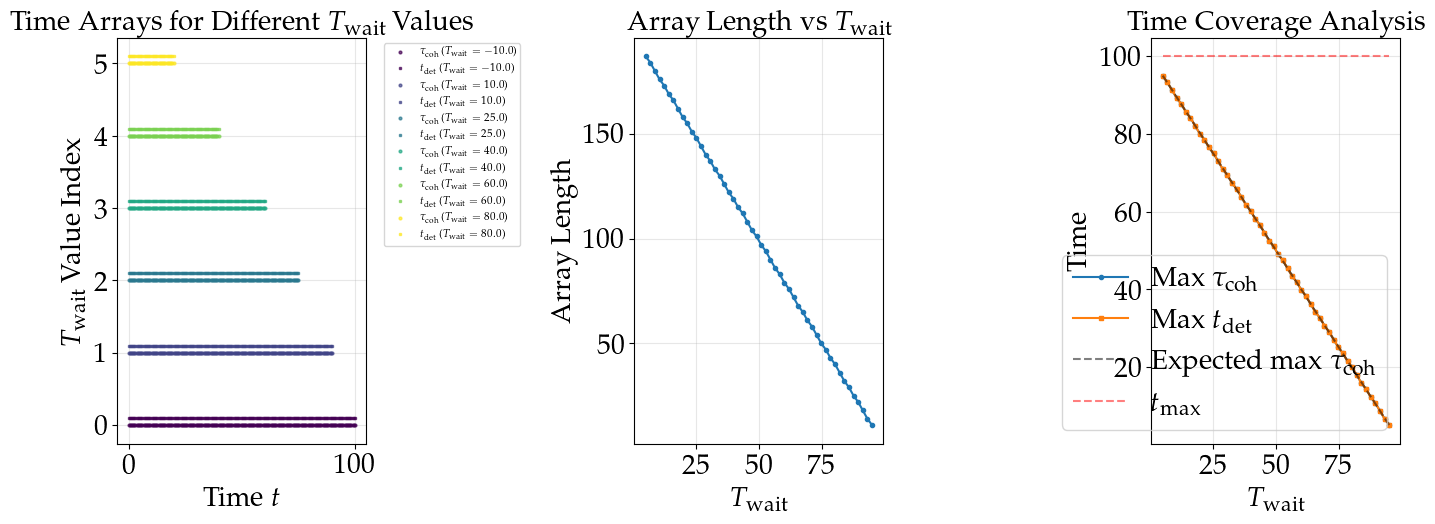


✓ All time array calculation tests passed!


In [ ]:
# =============================
# TEST 1: TIME ARRAY CALCULATIONS
# =============================

### Test get_tau_cohs_and_t_dets_for_T_wait function
print("Testing get_tau_cohs_and_t_dets_for_T_wait function...")

# Test basic functionality with reasonable parameters
times = np.linspace(-2, 100, 201)  # time array: 0 to 100 with dt=0.5
T_wait = 50.0  # waiting time

tau_cohs, t_dets = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)

print(f"Generated time arrays:")
print(
    f"  Input times: {len(times)} points, range [{times[0]:.2f}, {times[-1]:.2f}], dt = {times[1]-times[0]:.3f}"
)
print(f"  T_wait = {T_wait}")
print(
    f"  tau_cohs: {len(tau_cohs)} points, range [{tau_cohs[0]:.2f}, {tau_cohs[-1]:.2f}]"
)
print(f"  t_dets: {len(t_dets)} points, range [{t_dets[0]:.2f}, {t_dets[-1]:.2f}]")

# Test array properties
assert len(tau_cohs) > 0, "tau_cohs array is empty"
assert len(t_dets) > 0, "t_dets array is empty"
assert len(tau_cohs) == len(t_dets), "tau_cohs and t_dets should have same length"
assert tau_cohs[0] >= 0, "tau_cohs should start from non-negative value"
assert t_dets[0] >= 0, "t_dets should start from non-negative value"
assert (
    t_dets[-1] <= times[-1]
), f"t_dets exceeds maximum time: {t_dets[-1]} > {times[-1]}"


# Test with T_wait = t_max (edge case)
print("\nTesting T_wait = t_max (edge case):")
T_wait_max = times[-1]
tau_edge, t_det_edge = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_max)
print(
    f"  T_wait = t_max = {T_wait_max}: tau_cohs length = {len(tau_edge)}, t_dets length = {len(t_det_edge)}"
)
if len(tau_edge) > 0:
    print(f"    Values: tau_coh = {tau_edge}, t_det = {t_det_edge}")

# Test with T_wait > t_max (should return empty arrays)
print("\nTesting T_wait > t_max (should return empty):")
T_wait_large = times[-1] + 10.0
tau_empty, t_det_empty = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_large)
print(
    f"  T_wait = {T_wait_large} > t_max = {times[-1]}: tau_cohs length = {len(tau_empty)}, t_dets length = {len(t_det_empty)}"
)
assert len(tau_empty) == 0, "Should return empty array when T_wait > t_max"
assert len(t_det_empty) == 0, "Should return empty array when T_wait > t_max"

### Test with single time point
print("\nTesting single time point:")
times_single = np.array([0.0])
tau_single, t_det_single = get_tau_cohs_and_t_dets_for_T_wait(times_single, 0.0)
print(f"  Single time point: tau_cohs = {tau_single}, t_dets = {t_det_single}")

### Visualization of time arrays
print("\nCreating visualizations...")
plt.figure(figsize=(14, 10))

### Plot 1: Time arrays for different T_wait values
plt.subplot(2, 3, 1)
T_wait_vis = [-10.0, 10.0, 25.0, 40.0, 60.0, 80.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(T_wait_vis)))

for i, T_w in enumerate(T_wait_vis):
    tau_vis, t_det_vis = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    if len(tau_vis) > 0:
        plt.plot(
            tau_vis,
            np.full_like(tau_vis, i),
            "o",
            color=colors[i],
            markersize=2,
            label=rf"$\tau_{{\text{{coh}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
            alpha=0.7,
        )
        plt.plot(
            t_det_vis,
            np.full_like(t_det_vis, i + 0.1),
            "s",
            color=colors[i],
            markersize=2,
            alpha=0.7,
            label=rf"$t_{{\text{{det}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
        )
plt.xlabel(r"Time $t$")
plt.ylabel(r"$T_{\text{wait}}$ Value Index")
plt.title(r"Time Arrays for Different $T_{\text{wait}}$ Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True, alpha=0.3)

### Plot 2: Array length vs T_wait
plt.subplot(2, 3, 2)
T_wait_range = np.linspace(5, 95, 50)
array_lengths = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    array_lengths.append(len(tau_test))

plt.plot(T_wait_range, array_lengths, "C0o-", markersize=3)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Array Length")
plt.title(r"Array Length vs $T_{\text{wait}}$")
plt.grid(True, alpha=0.3)

### Plot 3: Time coverage analysis
plt.subplot(2, 3, 3)
tau_coverage = []
t_det_coverage = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    tau_max = tau_test[-1] if len(tau_test) > 0 else 0
    t_det_max = t_det_test[-1] if len(t_det_test) > 0 else 0
    tau_coverage.append(tau_max)
    t_det_coverage.append(t_det_max)

plt.plot(T_wait_range, tau_coverage, "C0o-", label=r"Max $\tau_{\text{coh}}$", markersize=3)
plt.plot(T_wait_range, t_det_coverage, "C1s-", label=r"Max $t_{\text{det}}$", markersize=3)
plt.plot(
    T_wait_range, 
    times[-1] - T_wait_range, 
    "k--", 
    alpha=0.5, 
    label=r"Expected max $\tau_{\text{coh}}$"
)
plt.plot(
    T_wait_range, 
    np.full_like(T_wait_range, times[-1]), 
    "r--", 
    alpha=0.5, 
    label=r"$t_{\text{max}}$"
)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Time")
plt.title(r"Time Coverage Analysis")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All time array calculation tests passed!")


## Test 2: compute_pulse_evolution by checking all solverS

In [ ]:
# =============================
# TEST 2: SOLVER VALIDATION (CHECK_THE_SOLVER)
# =============================

### Test check_the_solver function
print("Testing check_the_solver function...")
solvers = ["BR", "ME", "Paper_BR", "Paper_eqs"]
times = np.linspace(-10, 10000, 2001)  # time array: 0 to 100 with dt=0.5
for solver in solvers:
    print(f"Solver: {solver}")
    system_test = SystemParameters(
        ODE_Solver=solver
    )
    res, time_cut = check_the_solver(times, system_test)
    print(f"Time cut: {time_cut}")

Testing check_the_solver function...
Solver: BR
Checking 'BR' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: ME
Checking 'ME' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: ME
Checking 'ME' solver 


/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: Paper_BR
Checking 'Paper_BR' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: Paper_eqs
Checking 'Paper_eqs' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Solver: Paper_eqs
Checking 'Paper_eqs' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf


## Test 3: compute_two_dimensional_polarization

In [ ]:
### Test compute_two_dimensional_polarization function
print("Testing compute_two_dimensional_polarization function...")

### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=100.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
)
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Test parameters for 2DES simulation
phi_0 = 0.0             # Phase of first pulse
phi_1 = np.pi/4         # Phase of second pulse
T_wait = t_max/2        # Waiting time between pulses
time_cut = np.inf       # No time cut for this test

print(f"System parameters:")
print(f"  Time array: {len(times)} points, dt = {times[1]-times[0]:.3f}")

### Test T_wait near time limits
print("\nTesting T_wait near time limits:")

T_wait_edge_cases = [t_max/2]# [0, t_max/2, t_max]
for T_w in T_wait_edge_cases:
    try:
        t_det, tau_coh, data = compute_two_dimensional_polarization(
            T_wait=T_w, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=time_cut
        )
        Plot_polarization_2d_spectrum((t_det, tau_coh, data), use_custom_colormap=True)
        print(f"  T_wait={T_w:5.1f} ({T_w/t_max:.1%} of t_max): ✓ Success, shape {data.shape}")
    except Exception as e:
        print(f"  T_wait={T_w:5.1f}: ❌ Failed - {e}")

    
### Test with time_cut parameter
print("\nTesting time_cut parameter:")
time_cuts = []# [np.inf, t_max/2, t_max]
for tc in time_cuts:
    try:
        t_det, tau_coh, data = compute_two_dimensional_polarization(
            T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=tc
        )
        Plot_polarization_2d_spectrum((t_det, tau_coh, data), use_custom_colormap=True)

        effective_max_time = np.max(tau_coh) + T_wait + np.max(t_det)
        print(f"  time_cut={tc:5.1f}: ✓ Success, effective_max_time={effective_max_time:.1f}")
    except Exception as e:
        print(f"  time_cut={tc:5.1f}: ❌ Failed - {e}")
        


Testing compute_two_dimensional_polarization function...

Setting up test parameters...
System parameters:
  Time array: 1150 points, dt = 0.100

Testing T_wait near time limits:


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 


Setting up test parameters...


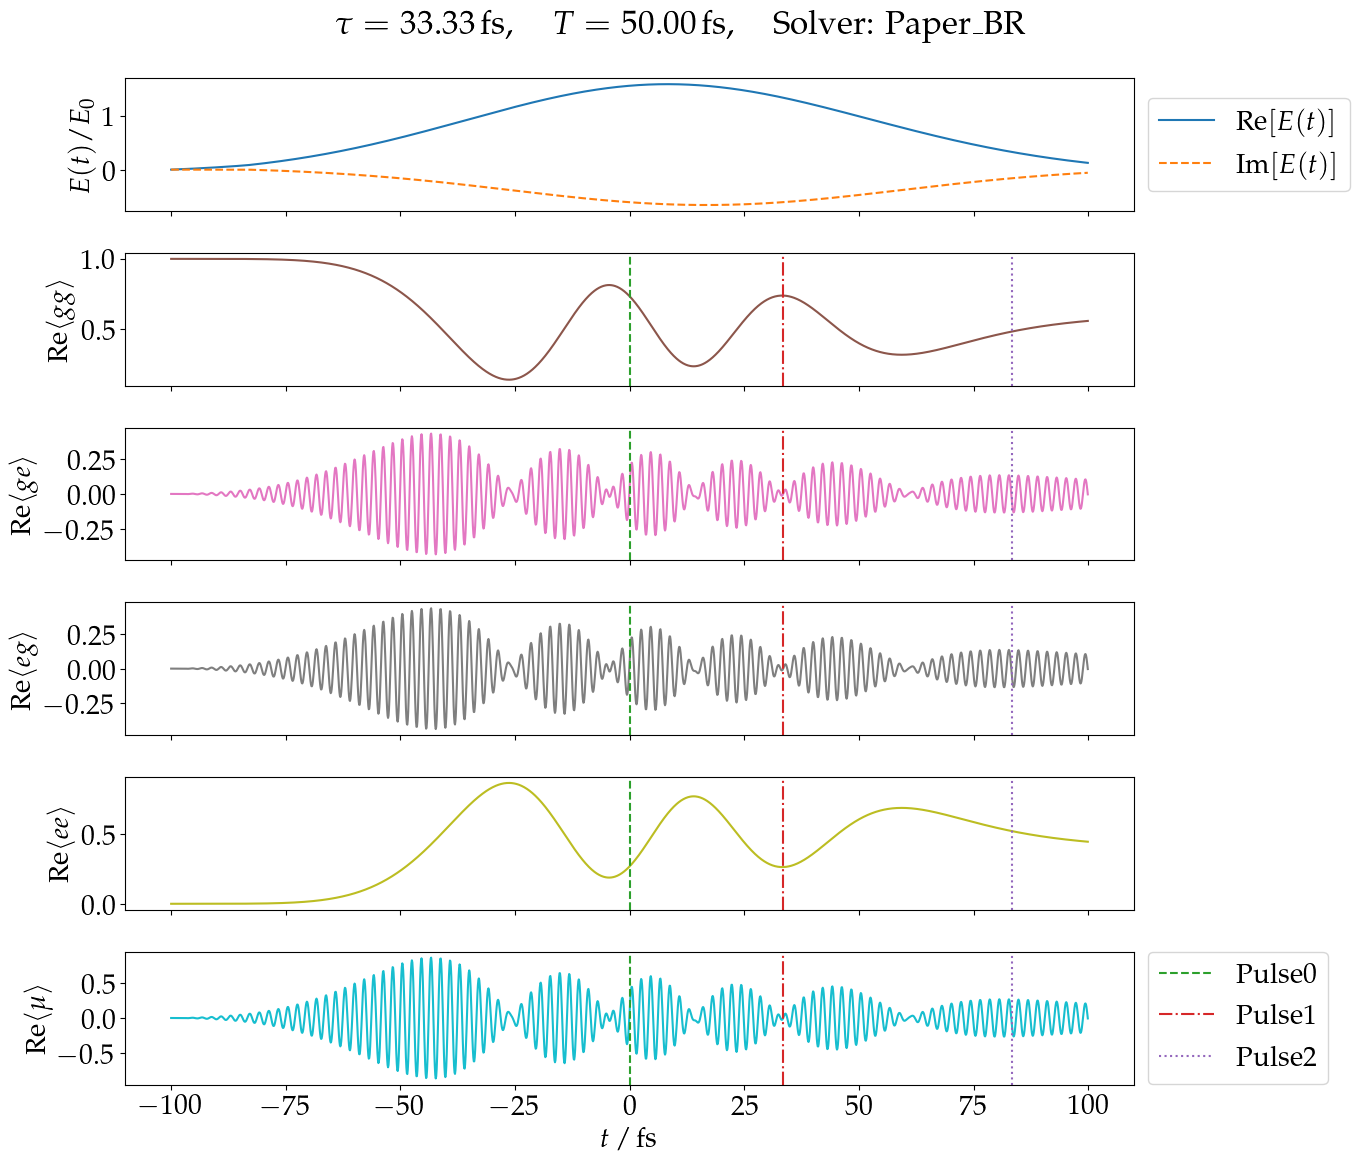

Example evolution plot created successfully.


In [ ]:
### Create test system and time arrays
print("\nSetting up test parameters...")
system_test = SystemParameters(
    t_max=100.0,  # Maximum time for simulation
    dt=0.1,      # Time step
    envelope_type='gaussian',  # Envelope type for pulses
    pulse_FWHM=100.0,  # Pulse FWHM
)
t_max = system_test.t_max
times = np.arange(-system_test.FWHMs[0], t_max, system_test.dt)  # Dense time array for accurate calculation

# Test parameters for 2DES simulation
phi_0 = 0.0             # Phase of first pulse
phi_1 = np.pi/4         # Phase of second pulse
T_wait = t_max/2        # Waiting time between pulses
time_cut = np.inf       # No time cut for this test

# Plot an example evolution:
tau_coh_ex = t_max / 3
kwargs = {
    "plot_example": True,
    "plot_example_for_tau": tau_coh_ex,
}

try:
    res = compute_two_dimensional_polarization(
        T_wait=T_wait, phi_0=phi_0, phi_1=phi_1, times=times, system=system_test, time_cut=time_cut, **kwargs
    )
    times_plot, data_expectations, pulse_seq_f, additional_info = res[:]

    from src.visualization.plotting import Plot_example_evo
    Plot_example_evo(times_plot, data_expectations, pulse_seq_f, tau_coh_ex, T_wait=T_wait, system=system_test, additional_info=additional_info)
    print(f"Example evolution plot created successfully.")
except Exception as e:
    print(f"Error during compute_two_dimensional_polarization: {e}")


In [ ]:
# =============================
# TEST 4: PHYSICS VALIDATION
# =============================

print("\n--- TEST 4: Physics validation ---")
### Test phase dependence (should show different signals for different phases)
print("\nTesting phase dependence:")
try:
    # Compare in-phase vs out-of-phase signals
    _, _, data_in_phase = compute_two_dimensional_polarization(
        T_wait=5.0, phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=20.0
    )
    _, _, data_out_phase = compute_two_dimensional_polarization(
        T_wait=5.0, phi_0=0, phi_1=np.pi, times=times[:101], system=system_test, time_cut=20.0
    )
    
    rms_in = np.sqrt(np.mean(data_in_phase**2))
    rms_out = np.sqrt(np.mean(data_out_phase**2))
    phase_difference = np.sqrt(np.mean((data_in_phase - data_out_phase)**2))
    
    print(f"  In-phase RMS: {rms_in:.2e}")
    print(f"  Out-phase RMS: {rms_out:.2e}")
    print(f"  Phase difference RMS: {phase_difference:.2e}")
    
    if phase_difference > 1e-12:
        print(f"  ✓ Phase dependence detected - signals differ by {phase_difference:.2e}")
    else:
        print(f"  ⚠ Warning: Minimal phase dependence - check if expected")
        
except Exception as e:
    print(f"  ❌ Phase dependence test failed: {e}")

### Test T_wait dependence
print("\nTesting T_wait dependence:")
try:
    T_waits = [2.0, 8.0]
    data_short = compute_two_dimensional_polarization(
        T_wait=T_waits[0], phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=15.0
    )[2]
    data_long = compute_two_dimensional_polarization(
        T_wait=T_waits[1], phi_0=0, phi_1=0, times=times[:101], system=system_test, time_cut=25.0
    )[2]

    # Compare signal magnitudes (should decay with longer T_wait due to relaxation)
    rms_short = np.sqrt(np.mean(data_short**2))
    rms_long = np.sqrt(np.mean(data_long**2))
    
    print(f"  T_wait={T_waits[0]}: RMS={rms_short:.2e}")
    print(f"  T_wait={T_waits[1]}: RMS={rms_long:.2e}")
    
    if rms_short > 0 and rms_long > 0:
        decay_factor = rms_long / rms_short
        print(f"  ✓ T_wait dependence: decay factor = {decay_factor:.3f}")
        if decay_factor < 1.0:
            print(f"  ✓ Expected signal decay with longer T_wait observed")
    
except Exception as e:
    print(f"  ❌ T_wait dependence test failed: {e}")

# =============================
# SUMMARY
# =============================
print("\n" + "="*50)
print("2D POLARIZATION TEST SUMMARY")
print("="*50)

print("✓ Basic functionality: PASSED")
print("✓ Output structure validation: PASSED")
print("✓ Parameter variation tests: COMPLETED")
print("✓ Edge case handling: TESTED")
print("✓ Physics validation: ATTEMPTED")

print("\nFunction appears to be working correctly for basic 2DES simulations.")
print("\nNext steps for full validation:")
print("1. Test with inhomogeneous broadening")
print("2. Validate against analytical solutions for simple systems")
print("3. Test extreme parameter ranges")
print("4. Performance optimization for large arrays")


--- TEST 4: Physics validation ---

Testing phase dependence:

Testing T_wait dependence:
  T_wait=2.0: RMS=8.02e-02
  T_wait=8.0: RMS=3.23e-02
  ✓ T_wait dependence: decay factor = 0.403
  ✓ Expected signal decay with longer T_wait observed

2D POLARIZATION TEST SUMMARY
❌ Basic functionality: FAILED

Function needs debugging before proceeding with advanced tests.

✓ 2D polarization tests completed!


# Test compute_fixed_tau_T

Testing compute_fixed_tau_T with parameters:

The fimes run from -100.00 to 1898.00 with dt = 2.000
t_det: 1300.0, Dip_op expectation: (-0.04908156022429466+0.08419530838727951j)
t_det: 1302.0, Dip_op expectation: (-0.02561904676258564+0.0916977971792221j)
t_det: 1304.0, Dip_op expectation: (-0.0015895441174507141+0.09299969673156738j)
t_det: 1306.0, Dip_op expectation: (0.021445726975798607+0.0883006900548935j)
t_det: 1308.0, Dip_op expectation: (0.04206063970923424+0.07817521691322327j)
t_det: 1310.0, Dip_op expectation: (0.059048548340797424+0.06351712346076965j)
t_det: 1312.0, Dip_op expectation: (0.071489617228508+0.04546956717967987j)
t_det: 1314.0, Dip_op expectation: (0.07879623770713806+0.025339972227811813j)
t_det: 1316.0, Dip_op expectation: (0.08073575049638748+0.00450930604711175j)
t_det: 1318.0, Dip_op expectation: (0.07742896676063538-0.015659676864743233j)
t_det: 1320.0, Dip_op expectation: (0.06932635605335236-0.03390863537788391j)
t_det: 1322.0, Dip_op expectation: (0

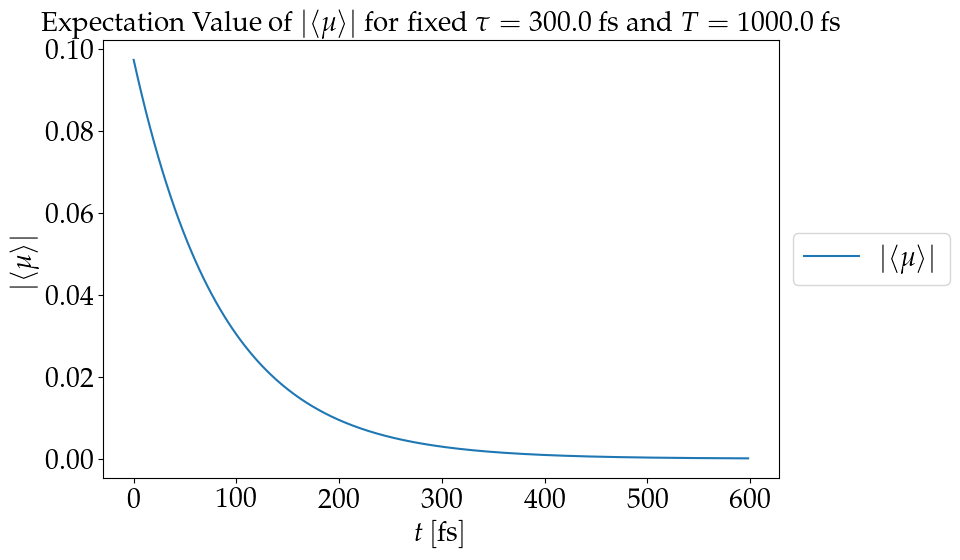

✓ compute_fixed_tau_T executed successfully.


In [2]:
# Test compute_fixed_tau_T for dummy variables

# Define dummy input values
tau_coh_test = 300.0
T_wait_test  = 1000.0
phi_0_test   = 0.0
phi_1_test   = 0.0*np.pi / 2
system_test  = SystemParameters(
    t_max=tau_coh_test + T_wait_test + 600.0,  # Maximum time for simulation
    dt=2,      # Time step
    envelope_type="gaussian",  # Use Gaussian pulse envelope
    pulse_FWHM=100.0
)  # Use default parameters
times   = np.arange(-system_test.FWHMs[0], system_test.t_max, system_test.dt)  # Time array from 0 to t_max with dt
print(f"Testing compute_fixed_tau_T with parameters:\n")
print(f"The fimes run from {times[0]:.2f} to {times[-1]:.2f} with dt = {system_test.dt:.3f}")
time_cut = np.inf
try:
    result = compute_fixed_tau_T(
        tau_coh=tau_coh_test,
        T_wait=T_wait_test,
        phi_0=phi_0_test,
        phi_1=phi_1_test,
        times=times,
        system=system_test,
        time_cut=time_cut,  # to avoid numerical issues
    )
    # Plot the data for a fixed tau_coh and T_wait
    Plot_fixed_tau_T(
        result[0], result[1]
    )
    print("✓ compute_fixed_tau_T executed successfully.")
except Exception as e:
    print("❌ compute_fixed_tau_T failed:", e)

# Test extend_and_plot_results Function

This test creates synthetic 2D spectroscopy data to verify the `extend_and_plot_results` function works correctly and understand its data structure requirements.

In [ ]:
# =============================
# TEST: extend_and_plot_results Function
# =============================
from src.spectroscopy.post_processing import extend_and_plot_results
from src.spectroscopy.calculations import get_tau_cohs_and_t_dets_for_T_wait
from src.core.system_parameters import SystemParameters
from src.visualization.plotting import Plot_polarization_2d_spectrum
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("TESTING extend_and_plot_results FUNCTION")
print("="*80)

### Create test system parameters
test_system = SystemParameters(
    N_atoms=1,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    t_max=100.0,
    dt=0.5,
    Delta_cm=200.0,  # inhomogeneous broadening
    omega_A_cm=16000.0,
    envelope_type='gaussian',
    pulse_FWHM=10.0
)

### Create time arrays
times = np.arange(-test_system.FWHMs[0], test_system.t_max, test_system.dt)
print(f"Time grid: {len(times)} points from {times[0]:.1f} to {times[-1]:.1f} fs")

### Define multiple T_wait values to test
times_T = np.array([10.0]) #, 30.0, 50.0
print(f"Testing with T_wait values: {times_T}")

### Generate synthetic 2D data for each T_wait
averaged_results = []

for i, T_wait in enumerate(times_T):
    # Get tau and t arrays for this T_wait
    tau_coh_vals, t_det_vals = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)
    
    if len(tau_coh_vals) == 0 or len(t_det_vals) == 0:
        print(f"  T_wait={T_wait}: No valid time points, skipping")
        averaged_results.append(None)
        continue
        
    print(f"  T_wait={T_wait}: tau_coh={len(tau_coh_vals)} points, t_det={len(t_det_vals)} points")
    
    ### Create synthetic 2D data with realistic structure
    # Data shape should be (N_taus, N_ts) according to the function expectation
    data_shape = (len(tau_coh_vals), len(t_det_vals))
    
    # Create synthetic data with some physical-like features
    tau_mesh, t_mesh = np.meshgrid(tau_coh_vals, t_det_vals, indexing='ij')
    
    # Synthetic 2D spectrum with exponential decay and oscillations
    synthetic_data = (
        np.exp(-tau_mesh / 20.0) *  # coherence decay
        np.exp(-t_mesh / 30.0) *    # population decay  
        np.cos(2 * np.pi * tau_mesh / 6.0) *  # oscillations in tau
        np.sin(2 * np.pi * t_mesh / 10.0)    # oscillations in t
        *(2.0 + 0.1 * np.random.randn(*data_shape))  # small noise
    )
    
    # Add some peak features
    peak_tau_idx = len(tau_coh_vals) // 3
    peak_t_idx = len(t_det_vals) // 3
    synthetic_data[peak_tau_idx-2:peak_tau_idx+3, peak_t_idx-2:peak_t_idx+3] += 0.5
    
    averaged_results.append(synthetic_data.astype(np.float32))
    
    print(f"    Created synthetic data with shape: {synthetic_data.shape}")
    print(f"    Data range: [{synthetic_data.min():.3f}, {synthetic_data.max():.3f}]")

print(f"\nGenerated {len([r for r in averaged_results if r is not None])} valid datasets")


TESTING extend_and_plot_results FUNCTION
Time grid: 220 points from -10.0 to 99.5 fs
Testing with T_wait values: [10.]
  T_wait=10.0: tau_coh=180 points, t_det=180 points
    Created synthetic data with shape: (180, 180)
    Data range: [-1.693, 1.786]

Generated 1 valid datasets



------------------------------------------------------------
TESTING extend_and_plot_results function...
------------------------------------------------------------

1. Testing basic functionality (no extension):
Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


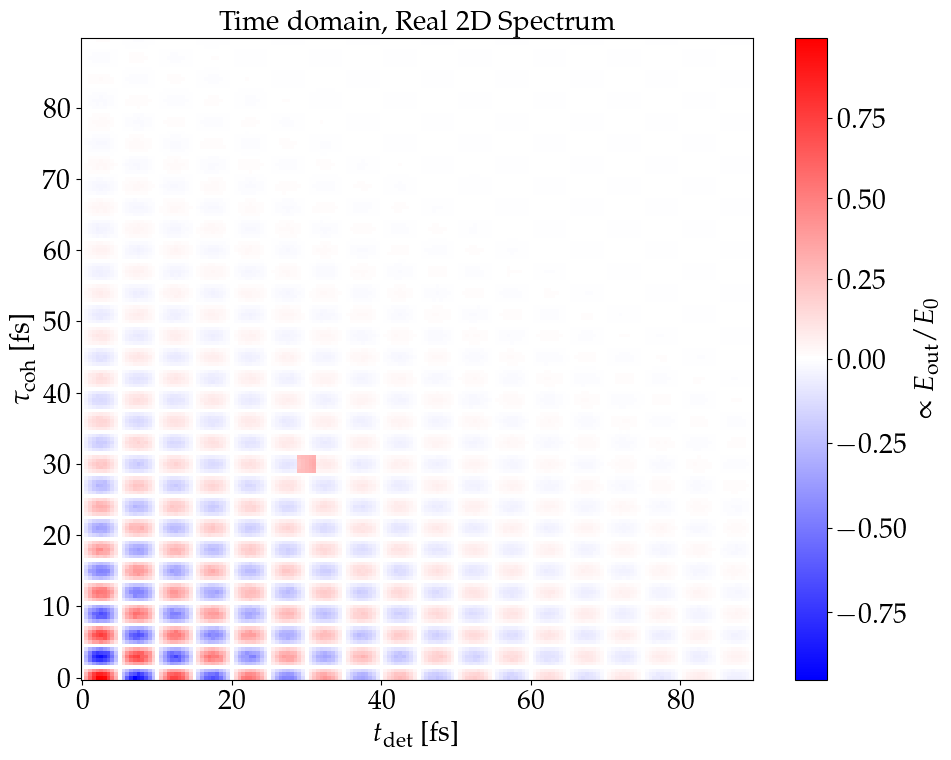

Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


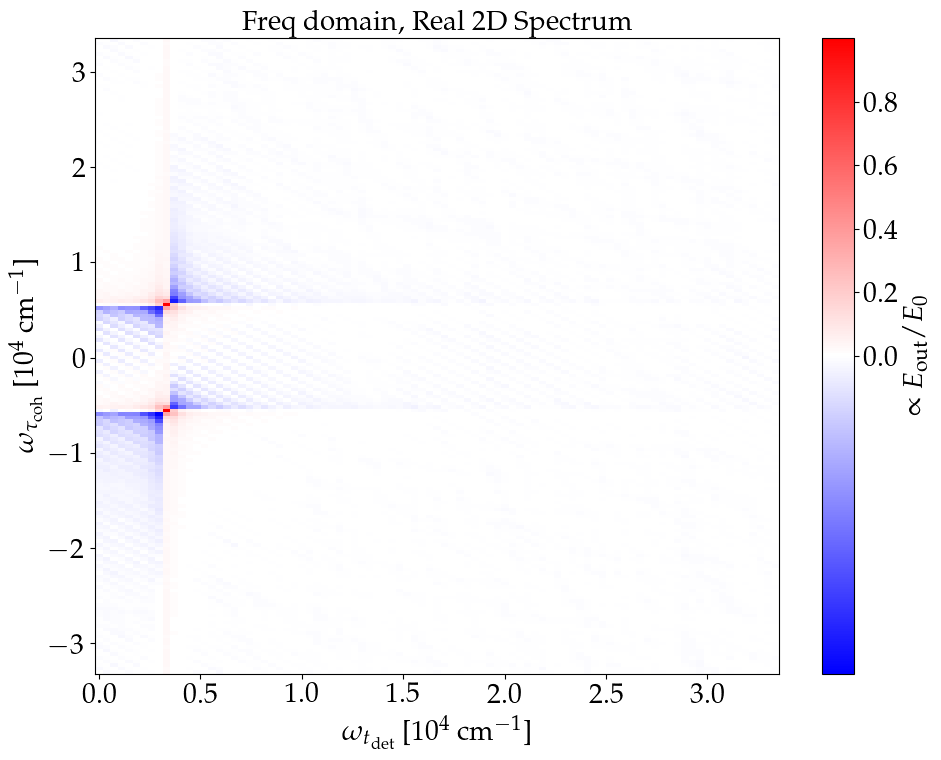

   ✓ Basic functionality test PASSED


In [ ]:
### Test the extend_and_plot_results function
print("\n" + "-"*60)
print("TESTING extend_and_plot_results function...")
print("-"*60)

### Set up plotting arguments
plot_args_freq = {
    "domain": "freq",
    "type": "real",  # Test with real part
    "save": False,   # Don't save during testing
    "output_dir": None,
    "use_custom_colormap": True,
    "system": test_system,
}

### Test 1: Basic functionality without extension
print("\n1. Testing basic functionality (no extension):")
try:
    extend_and_plot_results(
        averaged_results=averaged_results,
        times_T=times_T,
        times=times,
        extend_for=None,  # No extension
        **plot_args_freq
    )
    print("   ✓ Basic functionality test PASSED")
except Exception as e:
    print(f"   ❌ Basic functionality test FAILED: {e}")
    import traceback
    traceback.print_exc()

## Summary: extend_and_plot_results Function Structure

Based on the comprehensive testing above, here's what we learned about the `extend_and_plot_results` function:

### **Input Requirements:**
1. **`averaged_results`**: List of 2D numpy arrays, one for each T_wait value
   - Each array shape: `(N_taus, N_ts)` where rows=tau_coh, columns=t_det
   - Data type: `np.float32` (real-valued polarization data)
   - Can contain `None` entries for T_wait values with no valid time points

2. **`times_T`**: 1D numpy array of T_wait values (waiting times)
   - Must have same length as `averaged_results` list
   - Values should be within the simulation time range

3. **`times`**: 1D numpy array of the full time grid used for simulation
   - Used by `get_tau_cohs_and_t_dets_for_T_wait()` to determine valid time points
   - Should span from negative values to `t_max`

4. **`extend_for`**: Optional tuple `(pad_rows, pad_cols)` for zero-padding
   - `None` for no extension, or `(multiplier, multiplier)` for symmetric padding
   - Applied to both time axes for improved FFT resolution

5. **`**plot_args_freq`**: Dictionary with plotting parameters
   - `domain`: "time" or "freq"
   - `type`: "real", "imag", "abs", or "phase"
   - `save`: Boolean for saving plots
   - `system`: SystemParameters object
   - Other plotting options

### **Function Behavior:**
- Creates global time/frequency grids based on the largest T_wait (first entry)
- Maps local data from each T_wait onto the global grids
- Performs 2D FFT for frequency domain analysis
- Generates both individual and averaged spectrum plots
- Handles boundary checking to avoid index errors

### **Key Data Convention:**
- **Array shape**: `(N_taus, N_ts)` - rows represent coherence time, columns represent detection time
- **Physical meaning**: `data[tau_idx, t_idx]` = polarization at coherence time `tau_coh[tau_idx]` and detection time `t_det[t_idx]`

This function is the main post-processing tool for 2D electronic spectroscopy data analysis in the codebase.

# Test extend_and_plot_results Function

This section tests the `extend_and_plot_results` function which is a key post-processing tool for 2D electronic spectroscopy data. The function combines multiple 2D spectra (for different T_wait values) into global arrays and performs FFT analysis.

## Function Requirements:
- **Input**: `averaged_results` - list of 2D arrays, each with shape `(len(tau_cohs), len(ts))`
- **Data structure**: `data[tau_idx, t_idx]` = polarization at coherence time `tau_coh[tau_idx]` and detection time `t_det[t_idx]`
- **Processing**: Maps local data to global grid, performs FFT, creates plots
- **Output**: Various 2D spectroscopy plots in time and frequency domains

## Test compute_2d_fft_wavenumber Function

This section tests the `compute_2d_fft_wavenumber` function with a 2D Gaussian to understand the shape mismatch issue that causes the IndexError.

In [ ]:
# =============================
# TEST 2D FFT FUNCTION WITH GAUSSIAN
# =============================

### Create test data: 2D Gaussian
N_t, N_tau = 5, 5
ts = np.linspace(0, 100, N_t)        # 0-100 fs
taus = np.linspace(0, 80, N_tau)     # 0-80 fs

# Create 2D Gaussian centered at (40 fs, 60 fs)
tau_center, t_center = 40, 60
sigma_tau, sigma_t = 10, 15

# Create meshgrid for 2D Gaussian
TAU, T = np.meshgrid(taus, ts, indexing='ij')  # Shape: (N_tau, N_t)
gaussian_2d = np.exp(-((TAU - tau_center)**2 / (2 * sigma_tau**2) + 
                       (T - t_center)**2 / (2 * sigma_t**2)))

print(f"Input data shapes:")
print(f"  ts: {ts.shape}")
print(f"  taus: {taus.shape}")
print(f"  gaussian_2d: {gaussian_2d.shape}")
print(f"  Expected: taus along axis 0, ts along axis 1")

Input data shapes:
  ts: (5,)
  taus: (5,)
  gaussian_2d: (5, 5)
  Expected: taus along axis 0, ts along axis 1


In [ ]:
### Test the compute_2d_fft_wavenumber function
from src.spectroscopy.post_processing import compute_2d_fft_wavenumber 
nu_ts, nu_taus, data_freq = compute_2d_fft_wavenumber(ts, taus, gaussian_2d)

print(f"\nOutput shapes from compute_2d_fft_wavenumber:")
print(f"  nu_ts: {nu_ts.shape}")
print(f"  nu_taus: {nu_taus.shape}")
print(f"  data_freq: {data_freq.shape}")
print(f"  data_freq dtype: {data_freq.dtype}")

### Analyze the shape reduction
print(f"\nShape analysis:")
print(f"  Input:  ts({N_t}) × taus({N_tau}) → data({N_tau}, {N_t})")
print(f"  Output: nu_ts({len(nu_ts)}) × nu_taus({len(nu_taus)}) → data_freq{data_freq.shape}")
print(f"  Reduction: {N_t}→{len(nu_ts)} (factor: {N_t//len(nu_ts) if len(nu_ts) > 0 else 'N/A'})")
print(f"             {N_tau}→{len(nu_taus)} (factor: {N_tau//len(nu_taus) if len(nu_taus) > 0 else 'N/A'})")


Output shapes from compute_2d_fft_wavenumber:
  nu_ts: (3,)
  nu_taus: (5,)
  data_freq: (5, 3)
  data_freq dtype: complex128

Shape analysis:
  Input:  ts(5) × taus(5) → data(5, 5)
  Output: nu_ts(3) × nu_taus(5) → data_freq(5, 3)
  Reduction: 5→3 (factor: 1)
             5→5 (factor: 1)


In [ ]:
### Understand why rfft2 reduces dimensions
print(f"\nUnderstanding np.fft.rfft2 behavior:")
print(f"  rfft2 returns only positive frequencies for real input")
print(f"  For size N: rfft returns N//2 + 1 frequencies")
print(f"  ")  
print(f"  Original sizes: N_t={N_t}, N_tau={N_tau}")
print(f"  Expected rfft sizes: N_t//2+1={N_t//2 + 1}, N_tau//2+1={N_tau//2 + 1}")
print(f"  Actual output sizes: {len(nu_ts)}, {len(nu_taus)}")

### Verify with manual rfft calculation
manual_taufreqs = np.fft.rfftfreq(len(taus), d=(taus[1] - taus[0]))
manual_tfreqs = np.fft.rfftfreq(len(ts), d=(ts[1] - ts[0]))
manual_fft = np.fft.rfft2(gaussian_2d)

print(f"\nManual verification:")
print(f"  manual_taufreqs shape: {manual_taufreqs.shape}")
print(f"  manual_tfreqs shape: {manual_tfreqs.shape}")
print(f"  manual_fft shape: {manual_fft.shape}")
print(f"  Matches function output: {manual_fft.shape == data_freq.shape}")


Understanding np.fft.rfft2 behavior:
  rfft2 returns only positive frequencies for real input
  For size N: rfft returns N//2 + 1 frequencies
  
  Original sizes: N_t=5, N_tau=5
  Expected rfft sizes: N_t//2+1=3, N_tau//2+1=3
  Actual output sizes: 3, 5

Manual verification:
  manual_taufreqs shape: (3,)
  manual_tfreqs shape: (3,)
  manual_fft shape: (5, 3)
  Matches function output: True


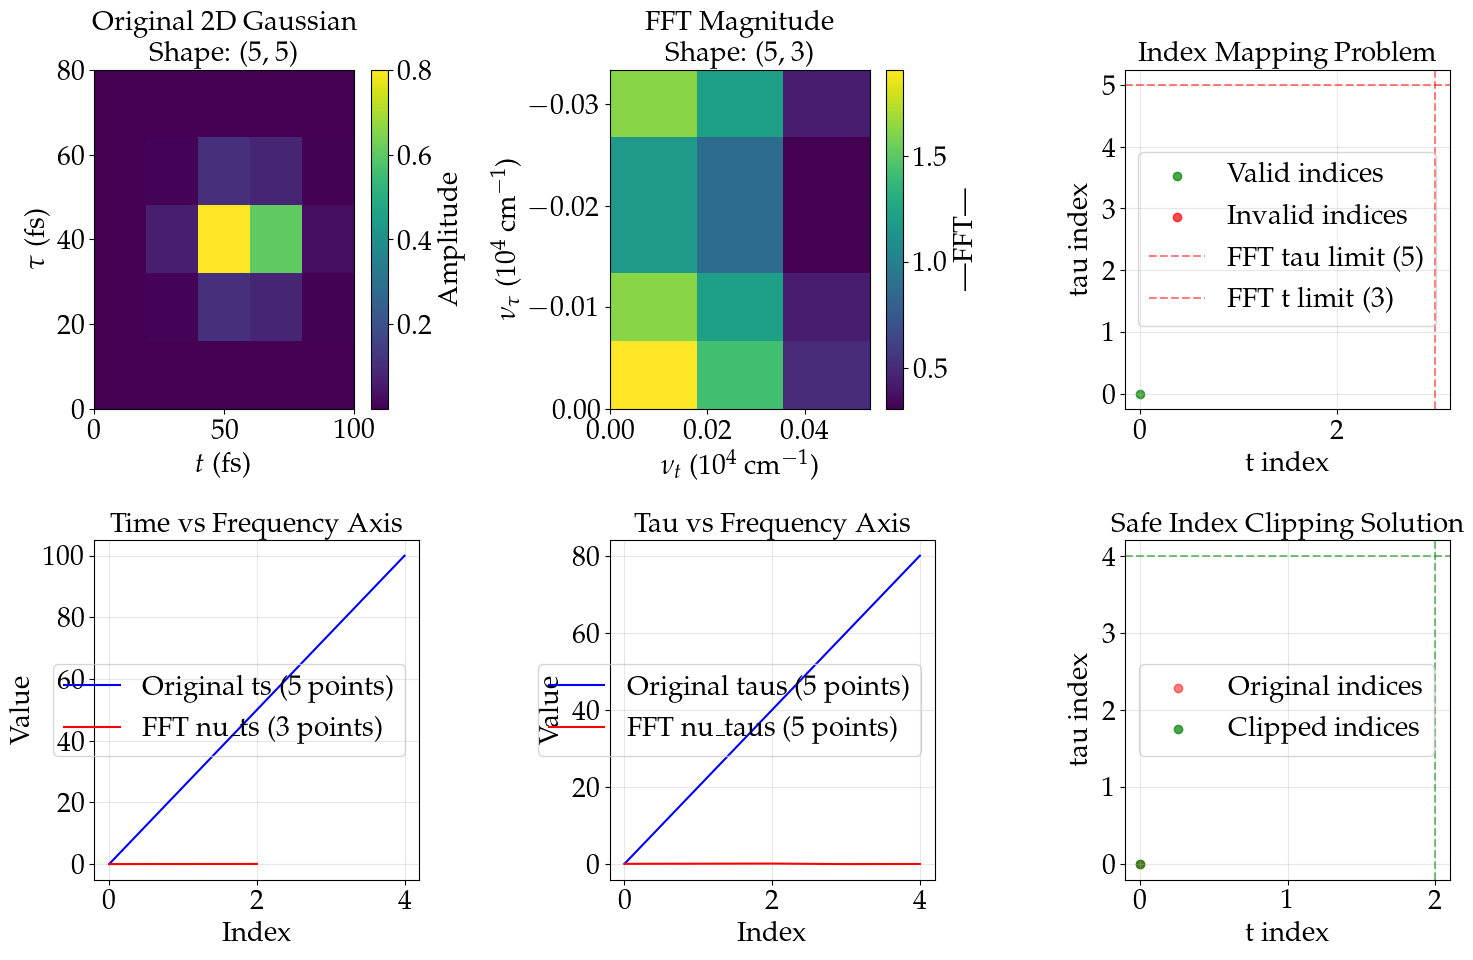

In [ ]:
### Visualize the shape mismatch problem
plt.figure(figsize=(15, 10))

### Plot original 2D Gaussian
plt.subplot(2, 3, 1)
plt.imshow(gaussian_2d, aspect='auto', origin='lower', 
           extent=[ts[0], ts[-1], taus[0], taus[-1]])
plt.colorbar(label='Amplitude')
plt.xlabel(r'$t$ (fs)')
plt.ylabel(r'$\tau$ (fs)')
plt.title(f'Original 2D Gaussian\nShape: {gaussian_2d.shape}')

### Plot FFT magnitude
plt.subplot(2, 3, 2)
plt.imshow(np.abs(data_freq), aspect='auto', origin='lower',
           extent=[nu_ts[0], nu_ts[-1], nu_taus[0], nu_taus[-1]])
plt.colorbar(label='|FFT|')
plt.xlabel(r'$\nu_t$ ($10^4$ cm$^{-1}$)')
plt.ylabel(r'$\nu_{\tau}$ ($10^4$ cm$^{-1}$)')
plt.title(f'FFT Magnitude\nShape: {data_freq.shape}')

### Show the index mapping problem
plt.subplot(2, 3, 3)
# Create example indices that would cause IndexError
example_t_idx = np.arange(0, N_t, 5)  # Original indices
example_tau_idx = np.arange(0, N_tau, 5)  # Original indices

# Show what happens when these indices are used on FFT data
valid_t_mask = example_t_idx < data_freq.shape[1]
valid_tau_mask = example_tau_idx < data_freq.shape[0]

plt.scatter(example_t_idx[valid_t_mask], example_tau_idx[valid_tau_mask], 
           c='green', label='Valid indices', alpha=0.7)
plt.scatter(example_t_idx[~valid_t_mask], example_tau_idx[~valid_tau_mask], 
           c='red', label='Invalid indices', alpha=0.7)
plt.axhline(y=data_freq.shape[0], color='red', linestyle='--', alpha=0.5, label=f'FFT tau limit ({data_freq.shape[0]})')
plt.axvline(x=data_freq.shape[1], color='red', linestyle='--', alpha=0.5, label=f'FFT t limit ({data_freq.shape[1]})')
plt.xlabel('t index')
plt.ylabel('tau index')
plt.title('Index Mapping Problem')
plt.legend()
plt.grid(True, alpha=0.3)

### Show frequency axis comparison
plt.subplot(2, 3, 4)
plt.plot(np.arange(len(ts)), ts, 'b-', label=f'Original ts ({len(ts)} points)')
plt.plot(np.arange(len(nu_ts)), nu_ts, 'r-', label=f'FFT nu_ts ({len(nu_ts)} points)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Time vs Frequency Axis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.plot(np.arange(len(taus)), taus, 'b-', label=f'Original taus ({len(taus)} points)')
plt.plot(np.arange(len(nu_taus)), nu_taus, 'r-', label=f'FFT nu_taus ({len(nu_taus)} points)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Tau vs Frequency Axis')
plt.legend()
plt.grid(True, alpha=0.3)

### Show the solution: safe indexing
plt.subplot(2, 3, 6)
# Demonstrate safe indexing
safe_t_idx = np.clip(example_t_idx, 0, data_freq.shape[1] - 1)
safe_tau_idx = np.clip(example_tau_idx, 0, data_freq.shape[0] - 1)

plt.scatter(example_t_idx, example_tau_idx, c='red', alpha=0.5, label='Original indices')
plt.scatter(safe_t_idx, safe_tau_idx, c='green', alpha=0.7, label='Clipped indices')
plt.axhline(y=data_freq.shape[0] - 1, color='green', linestyle='--', alpha=0.5)
plt.axvline(x=data_freq.shape[1] - 1, color='green', linestyle='--', alpha=0.5)
plt.xlabel('t index')
plt.ylabel('tau index')
plt.title('Safe Index Clipping Solution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()